# TensorFlow 2.0

## Embedding

You have words in a sentence and often words that have similar meanings are close to each other. So in a movie review, it might say that the movie was dull and boring, or it might say that it was fun and exciting. So what if you could pick a vector in a higher-dimensional space say 16 dimensions, and words that are found together are given similar vectors. Then over time, words can begin to cluster together. The meaning of the words can come from the labeling of the dataset. So in this case, we say a negative review and the words dull and boring show up a lot in the negative review so that they have similar sentiments, and they are close to each other in the sentence. Thus their vectors will be similar. As the neural network trains, it can then learn these vectors associating them with the labels to come up with what's called an embedding i.e., the vectors for each word with their associated sentiment. The results of the embedding will be a 2D array with the length of the sentence and the embedding dimension for example 16 as its size.

In [1]:
from platform import python_version

print(python_version())

3.6.10


In [4]:
import tensorflow as tf

In [3]:
tensorflow.__version__

'2.1.0'

In [6]:
import numpy as np
import tensorflow_datasets as tfds

imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

In [9]:
train_data.__iter__ #it's an iterable and numpy transforms the contents to string

<bound method DatasetV2.__iter__ of <_OptionsDataset shapes: ((), ()), types: (tf.string, tf.int64)>>

In [21]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
    training_sentences.append(str(s.numpy().decode('utf8')))
    training_labels.append(str(l.numpy()))
    
for s,l in test_data:
    testing_sentences.append(str(s.numpy().decode('utf8')))
    testing_labels.append(str(l.numpy()))

In [29]:
training_labels_final = np.array(training_labels).astype(float)
testing_labels_final = np.array(testing_labels).astype(float)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [24]:
#Reverse value and key to be able to decode
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

vanilla sky is a 2001 remake of the 1997 movie <OOV> los <OOV> open your eyes and in my opinion a much more human and emotional version tom cruise plays david <OOV> a selfish <OOV> who takes other people's emotions for granted and thinks only of himself jason lee plays brian <OOV> david's best and in many ways only friend penelope <OOV> plays <OOV> <OOV> <OOV> girlfriend whom <OOV> him to david's birthday party cameron diaz plays julie <OOV> david's occasional bed buddy kurt russell plays dr curtis <OOV> a psychologist <OOV> david all of their interactions and the consequences of them make vanilla sky one of the most emotional and complex thrillers ever made i won't explain anymore of
Vanilla Sky is a 2001 remake of the 1997 movie Abre Los Ojos (Open Your Eyes). And in my opinion, a much more human and emotional version. Tom Cruise plays David Aames, a selfish egomaniac who takes other people's emotions for granted, and thinks only of himself. Jason Lee plays Brian Shelby, David's best

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), #Magic Layer for embedding
    tf.keras.layers.Flatten(),
    #tf.keras.layers.GlobalAveragePooling1d() --> use alternatively if flattening is difficult
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 10s 411us/sample - loss: 0.4949 - accuracy: 0.7468 - val_loss: 0.3549 - val_accuracy: 0.8413
Epoch 2/10
25000/25000 [==============================] - 9s 361us/sample - loss: 0.2437 - accuracy: 0.9053 - val_loss: 0.3709 - val_accuracy: 0.8348
Epoch 3/10
25000/25000 [==============================] - 9s 373us/sample - loss: 0.1007 - accuracy: 0.9732 - val_loss: 0.4378 - val_accuracy: 0.8321
Epoch 4/10
25000/25000 [==============================] - 9s 343us/sample - loss: 0.0274 - accuracy: 0.9963 - val_loss: 0.5221 - val_accuracy: 0.8277
Epoch 5/10
25000/25000 [==============================] - 8s 333us/sample - loss: 0.0091 - accuracy: 0.9990 - val_loss: 0.5788 - val_accuracy: 0.8278
Epoch 6/10
25000/25000 [==============================] - 8s 334us/sample - loss: 0.0033 - accuracy: 0.9998 - val_loss: 0.6289 - val_accuracy: 0.8294
Epoch 7/10
25000/25000 [=========================

In [31]:
e = model.layers[0] #results in layer 0
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
#Write the vectors and their metadata auto files.
#The TensorFlow Projector reads this file type and uses it to plot the vectors in 3D space so we can visualize them

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    #To the metadata array, we just write out the words.
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    #To the vectors file, we write out the value of each of the items in the array of embeddings, i.e,
    #the co-efficient of each dimension on the vector for this word.
out_v.close()
out_m.close()

## Deep Recurrent Neural Networks (RNNs)

#### Long Short Term Memory (LSTM)

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).

In [34]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

tokenizer = info.features['text'].encoder

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to C:\Users\hheim\tensorflow_datasets\imdb_reviews\subwords8k\0.1.0. Subsequent calls will reuse this data.


In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), #Magic Layer for embedding
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #Instead of Flatten() and Global...()
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), --> multilayer lstm
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 202,253
Trainable params: 202,253
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
    
plot_graphs(history, 'accuracy')

## Sequence Models

Predict the last word in a sentence.

In [37]:
tokenizer = Tokenizer()

data="In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 #+1 for out of vocabulary words

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0] #turn words to codes based on tokenizer above
    for i in range(1, len(token_list)): #Turn one sencence to many, word 1, word 1 and 2, word 1,2,3 ...
        n_gram_sequence = token_list[:i+1] 
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences]) #Max of input_sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 64, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=2)

Train on 453 samples
Epoch 1/500
453/453 - 5s - loss: 5.5694 - accuracy: 0.0132
Epoch 2/500
453/453 - 0s - loss: 5.5494 - accuracy: 0.0596
Epoch 3/500
453/453 - 0s - loss: 5.5076 - accuracy: 0.0486
Epoch 4/500
453/453 - 0s - loss: 5.3708 - accuracy: 0.0508
Epoch 5/500
453/453 - 0s - loss: 5.1539 - accuracy: 0.0618
Epoch 6/500
453/453 - 0s - loss: 5.0712 - accuracy: 0.0486
Epoch 7/500
453/453 - 0s - loss: 5.0118 - accuracy: 0.0618
Epoch 8/500
453/453 - 0s - loss: 4.9655 - accuracy: 0.0552
Epoch 9/500
453/453 - 0s - loss: 4.9210 - accuracy: 0.0574
Epoch 10/500
453/453 - 0s - loss: 4.8775 - accuracy: 0.0552
Epoch 11/500
453/453 - 0s - loss: 4.8280 - accuracy: 0.0596
Epoch 12/500
453/453 - 0s - loss: 4.7742 - accuracy: 0.0596
Epoch 13/500
453/453 - 0s - loss: 4.7210 - accuracy: 0.0751
Epoch 14/500
453/453 - 0s - loss: 4.6680 - accuracy: 0.0839
Epoch 15/500
453/453 - 0s - loss: 4.6120 - accuracy: 0.0817
Epoch 16/500
453/453 - 0s - loss: 4.5566 - accuracy: 0.0905
Epoch 17/500
453/453 - 0s - 

Epoch 137/500
453/453 - 0s - loss: 1.2407 - accuracy: 0.8057
Epoch 138/500
453/453 - 0s - loss: 1.2318 - accuracy: 0.8035
Epoch 139/500
453/453 - 0s - loss: 1.2141 - accuracy: 0.8168
Epoch 140/500
453/453 - 0s - loss: 1.1975 - accuracy: 0.8190
Epoch 141/500
453/453 - 0s - loss: 1.1993 - accuracy: 0.8124
Epoch 142/500
453/453 - 0s - loss: 1.1892 - accuracy: 0.8168
Epoch 143/500
453/453 - 0s - loss: 1.1774 - accuracy: 0.8190
Epoch 144/500
453/453 - 0s - loss: 1.1696 - accuracy: 0.8168
Epoch 145/500
453/453 - 0s - loss: 1.1557 - accuracy: 0.8212
Epoch 146/500
453/453 - 0s - loss: 1.1461 - accuracy: 0.8124
Epoch 147/500
453/453 - 0s - loss: 1.1406 - accuracy: 0.8168
Epoch 148/500
453/453 - 0s - loss: 1.1242 - accuracy: 0.8278
Epoch 149/500
453/453 - 0s - loss: 1.1037 - accuracy: 0.8212
Epoch 150/500
453/453 - 0s - loss: 1.0882 - accuracy: 0.8300
Epoch 151/500
453/453 - 0s - loss: 1.0745 - accuracy: 0.8278
Epoch 152/500
453/453 - 0s - loss: 1.0632 - accuracy: 0.8278
Epoch 153/500
453/453 - 

Epoch 272/500
453/453 - 0s - loss: 0.3710 - accuracy: 0.9426
Epoch 273/500
453/453 - 0s - loss: 0.3691 - accuracy: 0.9448
Epoch 274/500
453/453 - 0s - loss: 0.3663 - accuracy: 0.9426
Epoch 275/500
453/453 - 0s - loss: 0.4017 - accuracy: 0.9448
Epoch 276/500
453/453 - 0s - loss: 0.4109 - accuracy: 0.9404
Epoch 277/500
453/453 - 0s - loss: 0.4211 - accuracy: 0.9382
Epoch 278/500
453/453 - 0s - loss: 0.4862 - accuracy: 0.9029
Epoch 279/500
453/453 - 0s - loss: 0.5187 - accuracy: 0.8962
Epoch 280/500
453/453 - 0s - loss: 0.4803 - accuracy: 0.9095
Epoch 281/500
453/453 - 0s - loss: 0.4513 - accuracy: 0.9183
Epoch 282/500
453/453 - 0s - loss: 0.4985 - accuracy: 0.9139
Epoch 283/500
453/453 - 0s - loss: 0.4624 - accuracy: 0.9272
Epoch 284/500
453/453 - 0s - loss: 0.4404 - accuracy: 0.9272
Epoch 285/500
453/453 - 0s - loss: 0.4111 - accuracy: 0.9360
Epoch 286/500
453/453 - 0s - loss: 0.4021 - accuracy: 0.9316
Epoch 287/500
453/453 - 0s - loss: 0.3861 - accuracy: 0.9316
Epoch 288/500
453/453 - 

Epoch 407/500
453/453 - 0s - loss: 0.1765 - accuracy: 0.9514
Epoch 408/500
453/453 - 0s - loss: 0.1768 - accuracy: 0.9470
Epoch 409/500
453/453 - 0s - loss: 0.1763 - accuracy: 0.9470
Epoch 410/500
453/453 - 0s - loss: 0.1752 - accuracy: 0.9514
Epoch 411/500
453/453 - 0s - loss: 0.1737 - accuracy: 0.9492
Epoch 412/500
453/453 - 0s - loss: 0.1728 - accuracy: 0.9470
Epoch 413/500
453/453 - 0s - loss: 0.1718 - accuracy: 0.9492
Epoch 414/500
453/453 - 0s - loss: 0.1716 - accuracy: 0.9514
Epoch 415/500
453/453 - 0s - loss: 0.1704 - accuracy: 0.9492
Epoch 416/500
453/453 - 0s - loss: 0.1699 - accuracy: 0.9492
Epoch 417/500
453/453 - 0s - loss: 0.1696 - accuracy: 0.9514
Epoch 418/500
453/453 - 0s - loss: 0.1681 - accuracy: 0.9426
Epoch 419/500
453/453 - 0s - loss: 0.1680 - accuracy: 0.9382
Epoch 420/500
453/453 - 0s - loss: 0.1673 - accuracy: 0.9492
Epoch 421/500
453/453 - 0s - loss: 0.1671 - accuracy: 0.9492
Epoch 422/500
453/453 - 0s - loss: 0.1697 - accuracy: 0.9426
Epoch 423/500
453/453 - 

In [44]:
seed_text = "Laurence went to dublin"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Laurence went to dublin girls the girls as at as red jig rose all all a daughter call call daughter father daughter stretched the right hall right hall glisten right but glisten glisten glisten hall glisten father hall hall hall hall died weeks a mchugh rose ogradys glisten then odaly glisten glisten father right hall right hall glisten glisten glisten glisten ask made them the wall ask ask ask plenty tea mavrone hearty hearty were ask ask ask water was glisten glisten fainted mavrone them mavrone were hearty hearty hearty hearty were ask ask ask water a hall hall hall hall hall glisten then


## Time Series

### Main characteristics

1) Trend: what direction is moving.
<br>
2) Seasonality: predictable patterns in data.
<br>
3) Autocorrelation: $v(t)=v(t-1)+spike$, it correlates with a lag or delayed copy of itself.

### Training, validation and testing

We typically want to split the time series into a training period, a validation period and a test period. This is called fixed partitioning. If the time series has some seasonality, you generally want to ensure that each period contains a whole number of seasons. For example, one year, or two years, or three years, if the time series has a yearly seasonality. You generally don't want one year and a half, or else some months will be represented more than others.

There's also another way. We start with a short training period, and we gradually increase it, say by one day at a time, or by one week at a time. At each iteration, we train the model on a training period. And we use it to forecast the following day, or the following week, in the validation period. And this is called roll-forward partitioning. You could see it as doing fixed partitioning a number of times, and then continually refining the model as such.

#### Features and outcomes

A window of data as the feature and the last value on that window as the outcome.


In [8]:
import tensorflow as tf 

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,
                         shift=1,
                         drop_remainder=True) #drop_remainder eliminates shorter than 5 lists
dataset = dataset.flat_map(lambda window: window.batch(5)) #numpy lists
for window in dataset:
    print(window.numpy(), type(window.numpy()))

[0 1 2 3 4] <class 'numpy.ndarray'>
[1 2 3 4 5] <class 'numpy.ndarray'>
[2 3 4 5 6] <class 'numpy.ndarray'>
[3 4 5 6 7] <class 'numpy.ndarray'>
[4 5 6 7 8] <class 'numpy.ndarray'>
[5 6 7 8 9] <class 'numpy.ndarray'>


In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:])) #Separate x -- first 4 values, y last value.
#list(map(lambda window: (window[:-1], window[-1:]), [[1,2,3],[4,5,6]])) --> elements are iterables
dataset = dataset.shuffle(buffer_size=10) #shuffle where buffer_size is len(data) to avoid sequence bias
dataset = dataset.batch(2).prefetch(1) #Batch creates a list of lists
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[1 2 3 4]
 [5 6 7 8]]
y =  [[5]
 [9]]
x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [[7]
 [6]]
x =  [[0 1 2 3]
 [4 5 6 7]]
y =  [[4]
 [8]]


In [18]:
#Artificial time series
import numpy as np

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

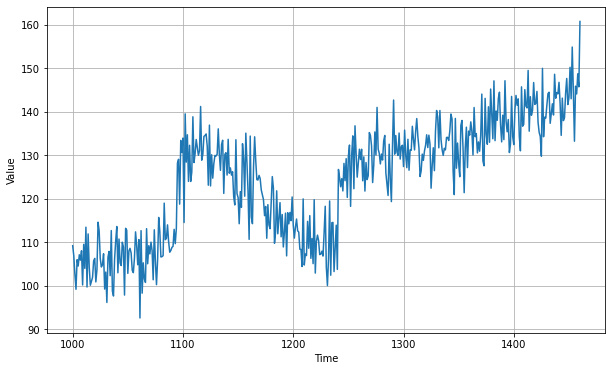

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20)) 
#callback to change learning rate at every epoch
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

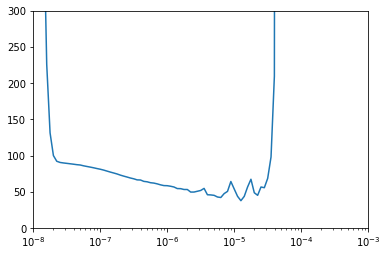

In [22]:
#Choose learning rate where stable and lowest

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

### Recurrent Neural Networks (RNNs)

A Recurrent Neural Network, or RNN is a neural network that contains recurrent layers. These are designed to sequentially processes sequence of inputs. RNNs are pretty flexible, able to process all kinds of sequences. The full input shape when using RNNs is three-dimensional. The first dimension will be the batch size, the second will be the timestamps, and the third is the dimensionality of the inputs at each time step. For example, if it's a univariate time series, this value will be one, for multivariate it'll be more. The models you've been using to date had two-dimensional inputs, the batch dimension was the first, and the second had all the input features.

At each time step, the memory cell takes the input value for that step. So for example, it is zero at time zero, and zero state input. It then calculates the output for that step, in this case Y0, and a state vector H0 that's fed into the next step. H0 is fed into the cell with X1 to produce Y1 and H1, which is then fed into the cell at the next step with X2 to produce Y2 and H2. These steps will continue until we reach the end of our input dimension, which in this case has 30 values. For numeric series, things such as closer numbers in the series might have a greater impact than those further away from our target value.

#### Dimensionality

Window = 30
<br>
Batch = 4
<br>
Number of neurons = 3

Dimensionality - (30,4,3)

The output matrix will be (batch size, number of neurons) per cell (30 if you have a window of 30). The state output, which is fed into the next layer of the cells, in a simple RNN is just a copy of the output $Y_i$.

In some cases, you might want to input a sequence, but you don't want to output on and you just want to get a single vector for each instance in the batch. This is typically called a sequence to vector RNN. But in reality, all you do is ignore all of the outputs, except the last one. When using Keras in TensorFlow, this is the default behavior. So if you want the recurrent layer to output a sequence, you have to specify returns sequences equals true when creating the layer. You'll need to do this when you stack one RNN layer on top of another.

In [24]:
tf.keras.backend.clear_session() #clears any internal variables. 
#that makes it easy for us to experiment without models impacting later versions of themselves.
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    #the window dataset helper function returned two-dimensional batches of Windows on the data,
    #with the first being the batch size and the second the number of timestamps. 
    #But an RNN expects three-dimensions; batch size, the number of timestamps, and the series dimensionality. 
    #By setting input shape to none, we're saying that the model can take sequences of any length.
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),,
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), #Huber loss to deal with outliers
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400, verbose=0)

### LSTMs

The impact of this is that while state is a factor in subsequent calculations, its impacts can diminish greatly over timestamps. LSTMs are the cell state to this that keep a state throughout the life of the training so that the state is passed from cell to cell, timestamp to timestamp, and it can be better maintained. This means that the data from earlier in the window can have a greater impact on the overall projection than in the case of RNNs. The state can also be bidirectional so that state moves forwards and backwards. In the case of texts, this was really powerful.

In [ ]:
tf.keras.backend.clear_session() #clears any internal variables. 

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), #remember return_sequences is necessary for
    #more than 1 layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

### Convolutions

